# Predicting Medical Cost

For this model, we are interested in how these different characteristics relate to the total medical cost, our aim is to build a Linear regression model to predict the medical costs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Load in the insurance dataset
insurance = pd.read_csv('insurance.csv')

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.shape

(1338, 7)

## Exploratory Analysis

In [5]:
# Columns in the dataset
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Since this is a supervised learning model, the charges column is our target while every other column can be used as our predictors

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

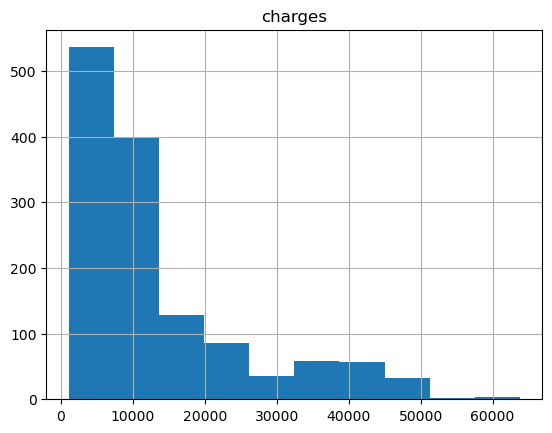

In [7]:
insurance.hist('charges')

The charges column is highly skewed to the right. Extremely cheap insurance charges are more common than extremely costly ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

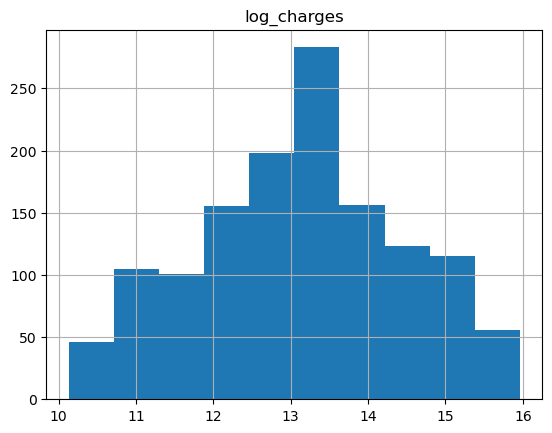

In [8]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

The log-transformed charges values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

In [9]:
# Checking the correlation between the continuous columns in the insurance data
insurance_continous = insurance.select_dtypes(exclude=['object'])
insurance_continous.corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


### Comments on correlation
age has 30% correlation with charges, bmi has 19.8% correlation, and number of children has 6.7% correlation.

Next we will use Box plots for the categorical variables to determine which one has a high correlation with our log charges

<AxesSubplot:title={'center':'log_charges'}, xlabel='sex'>

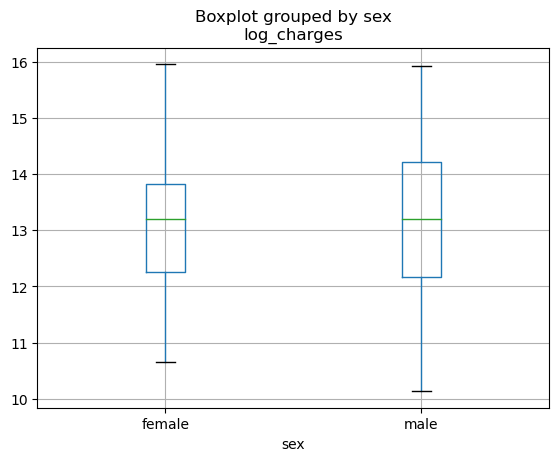

In [10]:
insurance.boxplot(column = ["log_charges"], by = "sex")

Males seem to have a wider distribution of charges compared to women

<AxesSubplot:title={'center':'log_charges'}, xlabel='smoker'>

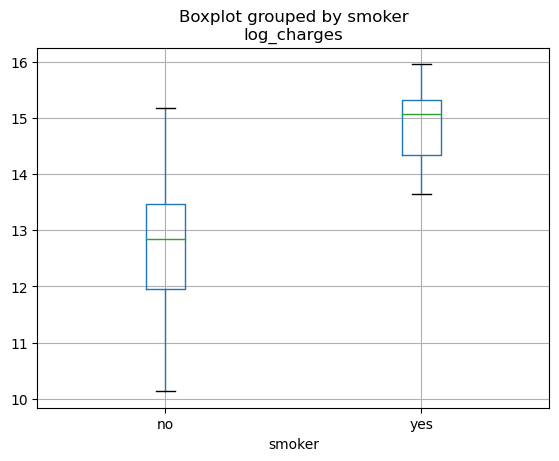

In [11]:
insurance.boxplot(column = ["log_charges"], by = "smoker")

Smokers have much higher costs than non-smokers

<AxesSubplot:title={'center':'log_charges'}, xlabel='region'>

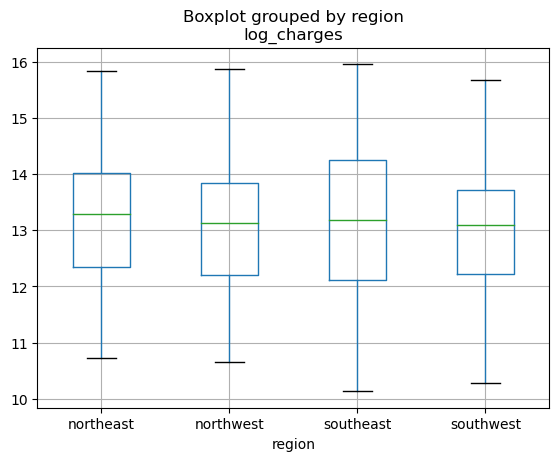

In [12]:
insurance.boxplot(column = ["log_charges"], by = "region")

Even though their is a slightly higher distribution in the Southeast, generally there doesn't seem to be many appreciable differences between regions.

### Dividing The Data
Based on the univariate relationships shown above, age, bmi and smokers are positively associated with higher charges. We'll include these predictors in our final model.

In [13]:
# first we seperate the smokers column as we need only the smokers and not the non smokers
insurance['is_smoker'] = (insurance['smoker'] == 'yes')

In [14]:
# We then split our data into X and y
X = insurance[['age', 'bmi', 'is_smoker']]
y = insurance['log_charges']

In [15]:
# Using train test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

## Build The Model
We are building the model with linear regrssion

In [16]:
model = LinearRegression()

In [17]:
# Training and checking model performance on training set
model.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_train)

In [19]:
# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.4546665339270644

In [20]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.575647870310887

In [21]:
# Coefficient of determination
r2_score(y_train, y_pred)

0.7421118855283421

### Comments
The training MSE for the model is 0.454 and is 1.57 on the original scale. This indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

### Residual Diagnostics

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

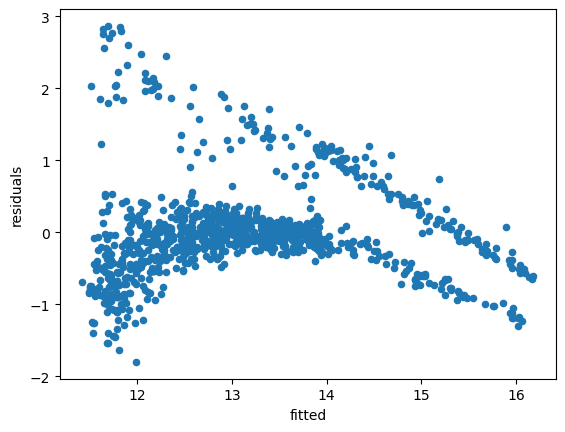

In [22]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_pred
check["fitted"] = y_pred

check.plot.scatter(x = "fitted", y = "residuals")

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

### Interpreting The Model

In [23]:
# Getting the non-intercept coefficients
model.coef_

array([0.04892865, 0.01523672, 2.23063344])

* A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
* A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.
* A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.


Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

## Final Model Evaluation

In [27]:
# Getting MSE on test model
test_pred = model.predict(X_test)

In [28]:
mean_squared_error(y_test, test_pred)

0.4355350875308212

In [29]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.5457899706350982

# Conclusion

The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.